# Simulating Readout Noise

## Theoretical Overview

Qubit-Readout can be corrupted in a variety of ways. The two most relevant error mechanisms on the Rigetti QPU right now are:

1. Transmission line noise that makes a 0-state look like a 1-state or vice versa. We call this **classical readout bit-flip error**. This type of readout noise can be reduced by tailoring optimal readout pulses and using superconducting, quantum limited amplifiers to amplify the readout signal before it is corrupted by classical noise at the higher temperature stages of our cryostats.
2. T1 qubit decay during readout (our readout operations can take more than a µsecond unless they have been specially optimized), which leads to readout signals that initially behave like 1-states but then collapse to something resembling a 0-state. We will call this **T1-readout error**. This type of readout error can be reduced by achieving shorter readout pulses relative to the T1 time, i.e., one can try to reduce the readout pulse length, or increase the T1 time or both.

## Qubit measurements

This section provides the necessary theoretical foundation for accurately modeling noisy quantum measurements on superconducting quantum processors. It relies on some of the abstractions (density matrices, Kraus maps) introduced in our notebook on [gate noise models](GateNoiseModels.ipynb).

The most general type of measurement performed on a single qubit at a single time can be characterized by some set $\mathcal{O}$ of measurement outcomes, e.g., in the simplest case $\mathcal{O} = \{0, 1\}$, and some unnormalized quantum channels (see notebook on gate noise models) that encapsulate
1. the probability of that outcome
2. how the qubit state is affected conditional on the measurement outcome.

Here the _outcome_ is understood as classical information that has been extracted from the quantum system.

### Projective, ideal measurement
The simplest case that is usually taught in introductory quantum mechanics and quantum information courses are Born's rule and the projection postulate which state that there exist a complete set of orthogonal projection operators 
$$
P_{\mathcal{O}} := \{\Pi_x \text{ Projector }\mid x \in \mathcal{O}\},
$$
i.e., one for each measurement outcome. Any projection operator must satisfy $\Pi_x^\dagger = \Pi_x = \Pi_x^2$ and for an _orthogonal_ set of projectors any two members satisfy 
$$
\Pi_x\Pi_y = \delta_{xy} \Pi_x = \begin{cases} 0 & \text{ if } x \ne y \\ \Pi_x & \text{ if } x = y \end{cases}
$$
and for a _complete_ set we additionally demand that $\sum_{x\in\mathcal{O}} \Pi_x = 1$.
Following our introduction to gate noise, we write quantum states as density matrices as this is more general and in closer correspondence with classical probability theory.

With these the probability of outcome $x$ is given by $p(x) = \tr{\Pi_x \rho \Pi_x} = \tr{\Pi_x^2 \rho} = \tr{\Pi_x \rho}$ and the post measurement state is
$$
\rho_x = \frac{1}{p(x)} \Pi_x \rho \Pi_x,
$$
which is the projection postulate applied to mixed states.

If we were a sloppy quantum programmer and accidentally erased the measurement outcome then our best guess for the post measurement state would be given by something that looks an awful lot like a Kraus map:
$$
\rho_{\text{post measurement}} = \sum_{x\in\mathcal{O}} p(x) \rho_x = \sum_{x\in\mathcal{O}} \Pi_x \rho \Pi_x.
$$
The completeness of the projector set ensures that the trace of the post measurement is still 1 and the Kraus map form of this expression ensures that $\rho_{\text{post measurement}}$ is a positive (semi-)definite operator.

### Classical readout bit-flip error

Consider now the ideal measurement as above, but where the outcome $x$ is transmitted across a noisy classical channel that produces a final outcome $x'\in \mathcal{O}' = \{0', 1'\}$ according to some conditional probabilities $p(x'|x)$ that can be recorded in the _assignment probability matrix_
$$
P_{x'|x} = \begin{pmatrix} 
p(0 | 0) & p(0 | 1) \\
p(1 | 0) & p(1 | 1)
\end{pmatrix}
$$
Note that this matrix has only two independent parameters as each column must be a valid probability distribution, i.e. all elements are non-negative and each column sums to 1.

This matrix allows us to obtain the probabilities $\mathbf{p}' := (p(x'=0), p(x'=1))^T$ from the original outcome probabilities $\mathbf{p} := (p(x=0), p(x=1))^T$  via $\mathbf{p}' = P_{x'|x}\mathbf{p}$.
The difference relative to the ideal case above is that now an outcome $x' = 0$ does not necessarily imply that the post measurement state is truly $\Pi_{0} \rho \Pi_{0} / p(x=0)$. Instead, the post measurement state given a noisy outcome $x'$ must be
\begin{align}
\rho_{x'} & = \sum_{x\in \mathcal{O}} p(x|x') \rho_x \\
          & = \sum_{x\in \mathcal{O}} p(x'|x)\frac{p(x)}{p(x')} \rho_x \\
          & = \frac{1}{p(x')}\sum_{x\in \mathcal{O}} p(x'|x) \Pi_x \rho \Pi_x
\end{align}
where 
\begin{align}
p(x') & = \sum_{x\in\mathcal{O}} p(x'|x) p(x)  \\
& = \tr{\sum_{x\in \mathcal{O}} p(x'|x) \Pi_x \rho \Pi_x} \\
& = \tr{\rho \sum_{x\in \mathcal{O}} p(x'|x)\Pi_x} \\
& = \tr{\rho E_x'}.
\end{align}
where we have exploited the cyclical property of the trace $\tr{ABC}=\tr{BCA}$ and the projection property $\Pi_x^2 = \Pi_x$. This has allowed us to derive the noisy outcome probabilities from a set of positive operators
$$
E_{x'} := \sum_{x\in \mathcal{O}} p(x'|x)\Pi_x \ge 0
$$
that must sum to 1: 
$$
\sum_{x'\in\mathcal{O}'} E_x' = \sum_{x\in\mathcal{O}}\underbrace{\left[\sum_{x'\in\mathcal{O}'} p(x'|x)\right]}_{1}\Pi_x = \sum_{x\in\mathcal{O}}\Pi_x = 1.
$$
The above result is a type of generalized **Bayes' theorem** that is extremely useful for this type of (slightly) generalized measurement and the family of operators $\{E_{x'}| x' \in \mathcal{O}'\}$ whose expectations give the probabilities is called a **positive operator valued measure** (POVM). These operators are not generally orthogonal nor valid projection operators but they naturally arise in this scenario. This is not yet the most general type of measurement, but it will get us pretty far.

### How to model $T_1$ error
T1 type errors fall outside our framework so far as they involve a scenario in which the _quantum state itself_ is corrupted during the measurement process in a way that potentially erases the pre-measurement information as opposed to a loss of purely classical information. The most appropriate framework for describing this is given by that of measurement instruments, but for the practical purpose of arriving at a relatively simple description, we propose describing this by a T1 damping Kraus map followed by the noisy readout process as described above.

### Further reading
Chapter 3 of John Preskill's lecture notes http://www.theory.caltech.edu/people/preskill/ph229/notes/chap3.pdf

## How do I get started?

1. Come up with a good guess for your readout noise parameters $p(0|0)$ and $p(1|1)$, the off-diagonals then follow from the normalization of $P_{x'|x}$. If your assignment fidelity $F$ is given, and you assume that the classical bit flip noise is roughly symmetric, then a good approximation is to set $p(0|0)=p(1|1)=F$.
2. For your QUIL program `p`, and a qubit index `q` call:
    ```
    p.define_noisy_readout(q, p00, p11)
    ```
    where you should replace `p00` and `p11` with the assumed probabilities.

### Estimate $P_{x'|x}$ yourself!
You can also run some simple experiments to estimate the assignment probability matrix directly from a QPU.

**Scroll down for some examples!**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pyquil.quil import Program, MEASURE, Pragma
from pyquil.api import QVMConnection
from pyquil.gates import I, X, RX, H, CNOT
from pyquil.noise import (estimate_bitstring_probs, correct_bitstring_probs, 
                          bitstring_probs_to_z_moments, estimate_assignment_probs)

DARK_TEAL = '#48737F'
FUSCHIA = '#D6619E'
BEIGE = '#EAE8C6'

cxn = QVMConnection()

## Example 1: Rabi sequence with noisy readout

In [2]:
%%time

# number of angles
num_theta = 101

# number of program executions
trials = 200

thetas = np.linspace(0, 2*np.pi, num_theta)

p00s = [1., 0.95, 0.9, 0.8]

results_rabi = np.zeros((num_theta, len(p00s)))

for jj, theta in enumerate(thetas):
    for kk, p00 in enumerate(p00s):
        cxn.random_seed = hash((jj, kk))
        p = Program(RX(theta, 0))
        ro = p.declare("ro")
        # assume symmetric noise p11 = p00
        p.define_noisy_readout(0, p00=p00, p11=p00)
        p.measure(0, ro[0])
        res = cxn.run(p, [0], trials=trials)
        results_rabi[jj, kk] = np.sum(res)


CPU times: user 875 ms, sys: 50.4 ms, total: 925 ms
Wall time: 2.23 s


Text(0.5, 1.0, 'Effect of classical readout noise on Rabi contrast.')

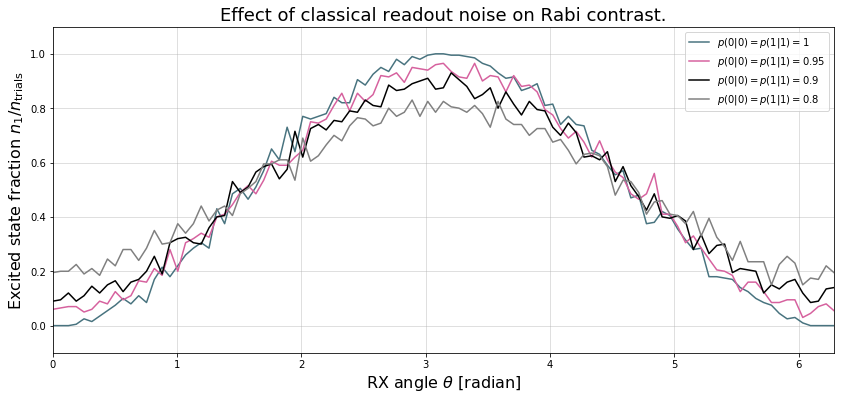

In [3]:
plt.figure(figsize=(14, 6))
for jj, (p00, c) in enumerate(zip(p00s, [DARK_TEAL, FUSCHIA, "k", "gray"])):
    plt.plot(thetas, results_rabi[:, jj]/trials, c=c, label=r"$p(0|0)=p(1|1)={:g}$".format(p00))
plt.legend(loc="best")
plt.xlim(*thetas[[0,-1]])
plt.ylim(-.1, 1.1)
plt.grid(alpha=.5)
plt.xlabel(r"RX angle $\theta$ [radian]", size=16)
plt.ylabel(r"Excited state fraction $n_1/n_{\rm trials}$", size=16)
plt.title("Effect of classical readout noise on Rabi contrast.", size=18)

## Example 2: Estimate the assignment probabilities

### Estimate assignment probabilities for a perfect quantum computer

In [4]:
estimate_assignment_probs(0, 1000, cxn, Program())

/Users/peter/.pyenv/versions/3.6.3/envs/forest-tutorials/lib/python3.6/site-packages/pyquil/quil.py:979: UserWarning: Please DECLARE all memory. I'm adding a declaration for the `ro` register, but I won't do this for you in the future.
  "Please DECLARE all memory. I'm adding a declaration for the `ro` register, "


array([[1., 0.],
       [0., 1.]])

### Re-Estimate assignment probabilities for an imperfect quantum computer

In [5]:
cxn.seed = None
header0 = Program().define_noisy_readout(0, .85, .95)
header1 = Program().define_noisy_readout(1, .8, .9)
header2 = Program().define_noisy_readout(2, .9, .85)

ap0 = estimate_assignment_probs(0, 100000, cxn, header0)
ap1 = estimate_assignment_probs(1, 100000, cxn, header1)
ap2 = estimate_assignment_probs(2, 100000, cxn, header2)

In [6]:
print(ap0, ap1, ap2, sep="\n")

[[0.84949 0.05007]
 [0.15051 0.94993]]
[[0.79957 0.10064]
 [0.20043 0.89936]]
[[0.89964 0.15048]
 [0.10036 0.84952]]


## Example 3: Use `pyquil.noise.correct_bitstring_probs` to correct for noisy readout

### 3a) Correcting the Rabi signal from above

In [7]:
ap_last = np.array([[p00s[-1], 1 - p00s[-1]], 
                    [1 - p00s[-1], p00s[-1]]])
corrected_last_result = [correct_bitstring_probs([1-p, p], [ap_last])[1] for p in results_rabi[:, -1] / trials]

Text(0.5, 1.0, 'Corrected contrast')

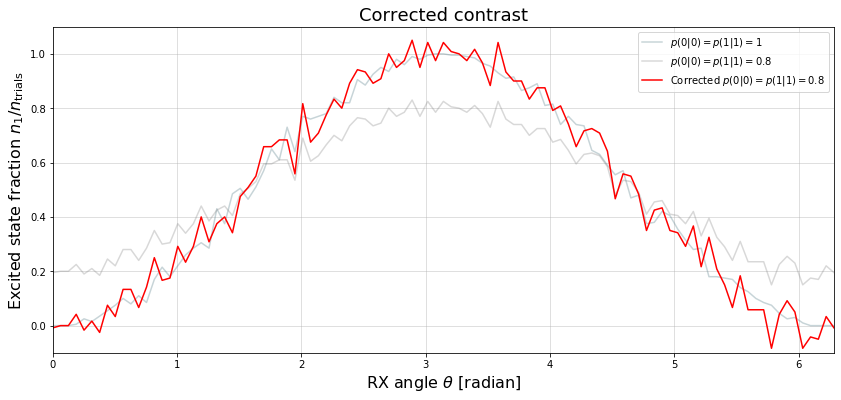

In [8]:
plt.figure(figsize=(14, 6))
for jj, (p00, c) in enumerate(zip(p00s, [DARK_TEAL, FUSCHIA, "k", "gray"])):
    if jj not in [0, 3]:
        continue
    plt.plot(thetas, results_rabi[:, jj]/trials, c=c, label=r"$p(0|0)=p(1|1)={:g}$".format(p00), alpha=.3)
plt.plot(thetas, corrected_last_result, c="red", label=r"Corrected $p(0|0)=p(1|1)={:g}$".format(p00s[-1]))
plt.legend(loc="best")
plt.xlim(*thetas[[0,-1]])
plt.ylim(-.1, 1.1)
plt.grid(alpha=.5)
plt.xlabel(r"RX angle $\theta$ [radian]", size=16)
plt.ylabel(r"Excited state fraction $n_1/n_{\rm trials}$", size=16)
plt.title("Corrected contrast", size=18)

**We find that the corrected signal is fairly noisy (and sometimes exceeds the allowed interval $[0,1]$) due to the overall very small number of samples $n=200$.**

### 3b) In this example we will create a GHZ state $\frac{1}{\sqrt{2}}\left[\left|000\right\rangle + \left|111\right\rangle \right]$ and measure its outcome probabilities with and without the above noise model. We will then see how the Pauli-Z moments that indicate the qubit correlations are corrupted (and corrected) using our API.

In [9]:
ghz_prog = Program()
ro = ghz_prog.declare("ro", "BIT", 3)
ghz_prog += H(0)
ghz_prog += CNOT(0, 1)
ghz_prog += CNOT(1, 2)
ghz_prog += MEASURE(0, ro[0])
ghz_prog += MEASURE(1, ro[1])
ghz_prog += MEASURE(2, ro[2])
print(ghz_prog)
results = cxn.run(ghz_prog, [0, 1, 2], trials=10000)

DECLARE ro BIT[3]
H 0
CNOT 0 1
CNOT 1 2
MEASURE 0 ro[0]
MEASURE 1 ro[1]
MEASURE 2 ro[2]



In [10]:
header = header0 + header1 + header2
noisy_ghz = header + ghz_prog
print(noisy_ghz)
noisy_results = cxn.run(noisy_ghz, [0, 1, 2], trials=10000)

PRAGMA READOUT-POVM 0 "(0.85 0.050000000000000044 0.15000000000000002 0.95)"
PRAGMA READOUT-POVM 1 "(0.8 0.09999999999999998 0.19999999999999996 0.9)"
PRAGMA READOUT-POVM 2 "(0.9 0.15000000000000002 0.09999999999999998 0.85)"
DECLARE ro BIT[3]
H 0
CNOT 0 1
CNOT 1 2
MEASURE 0 ro[0]
MEASURE 1 ro[1]
MEASURE 2 ro[2]



### Uncorrupted probability for $\left|000\right\rangle$ and $\left|111\right\rangle$

In [11]:
probs = estimate_bitstring_probs(results)
probs[0, 0, 0], probs[1, 1, 1]

(0.4959, 0.5041)

As expected the outcomes `000` and `111` each have roughly probability $1/2$.

### Corrupted probability for $\left|000\right\rangle$ and $\left|111\right\rangle$

In [12]:
noisy_probs = estimate_bitstring_probs(noisy_results)
noisy_probs[0, 0, 0], noisy_probs[1, 1, 1]

(0.3093, 0.3611)

The noise-corrupted outcome probabilities deviate significantly from their ideal values!

### Corrected probability for $\left|000\right\rangle$ and $\left|111\right\rangle$

In [13]:
corrected_probs = correct_bitstring_probs(noisy_probs, [ap0, ap1, ap2])
corrected_probs[0, 0, 0], corrected_probs[1, 1, 1]

(0.5054052808756202, 0.4957404969469219)

The corrected outcome probabilities are much closer to the ideal value.

### Estimate $\langle Z_0^{j} Z_1^{k} Z_2^{\ell}\rangle$ for $jkl=100, 010, 001$ from non-noisy data
*We expect these to all be very small*

In [14]:
zmoments = bitstring_probs_to_z_moments(probs)
zmoments[1, 0, 0], zmoments[0, 1, 0], zmoments[0, 0, 1]

(-0.008199999999999985, -0.008199999999999985, -0.008199999999999985)

### Estimate $\langle Z_0^{j} Z_1^{k} Z_2^{\ell}\rangle$ for $jkl=110, 011, 101$ from non-noisy data
*We expect these to all be close to 1.*

In [15]:
zmoments[1, 1, 0], zmoments[0, 1, 1], zmoments[1, 0, 1]

(1.0, 1.0, 1.0)

### Estimate $\langle Z_0^{j} Z_1^{k} Z_2^{\ell}\rangle$ for $jkl=100, 010, 001$ from noise-corrected data

In [16]:
zmoments_corr = bitstring_probs_to_z_moments(corrected_probs)
zmoments_corr[1, 0, 0], zmoments_corr[0, 1, 0], zmoments_corr[0, 0, 1]

(0.005804208050837423, 0.012290215042994768, 0.009450584654813854)

### Estimate $\langle Z_0^{j} Z_1^{k} Z_2^{\ell}\rangle$ for $jkl=110, 011, 101$ from noise-corrected data

In [17]:
zmoments_corr[1, 1, 0], zmoments_corr[0, 1, 1], zmoments_corr[1, 0, 1]

(1.0242766053748604, 0.9909609480429594, 0.9893455578723482)

##### Overall the correction can restore the contrast in our multi-qubit observables, though we also see that the correction can lead to slightly non-physical expectations. This effect is reduced the more samples we take.